## DQN & DDQN Implementation Exercise
Before beginning this exercise, we highly recommend you read through the [DQN Derivation](dqn_derivation.ipynb) tutorial to get a better grasp of the math behind DQN.

Initializing the environment:

In [1]:
import metadrive  # Import this package to register the environment!
import gymnasium as gym
from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


#### Discretization

In order to use a DQN, we need to discretize the action space.
<details><summary>Why?</summary>

$$Q^{\pi}(s_t, a_t) \leftarrow \left(r_{t+1} + \argmax_{a \in A} Q^{\pi}(s_{t+1}, a) \right)$$

- The above update rule also only works in discretized environments, as $\argmax_{a \in A} Q^{\pi}(s_{t+1}, a)$ is intractable to calculate if there are infinite possible actions.
</details>

We'll use the same approach as in the Discrete Policy Gradient Notebook.

In [2]:
import numpy as np
import numpy.typing as npt

NUM_ACTIONS = 5

def discrete2continuous(action:int) -> npt.NDArray[np.float32]:
    """
    Convert discrete action to continuous action
    """
    assert 0 <= action < NUM_ACTIONS
    throttle_magnitude = 0.5
    brake_magnitude = 1.0
    steering_magnitude = 1.0
    match action:
        case 0:
            return np.array([steering_magnitude, 0.0])
        case 1:
            return np.array([0.0, throttle_magnitude])
        case 2:
            return np.array([0.0, -brake_magnitude])
        case 3:
            return np.array([-steering_magnitude, 0.0])
        case 4:
            return np.array([0.0, 0.0])


### Creating a DQN
Our next task is to create a Deep Q-Network: a network that is able to predict the Q value for every action. Since our observation space is an image, we'll use a convolutional network. The overall shape of the network will be similar to the one we used in the Policy Gradient notebook.

Note: Don't add an activation to the last layer. 

<details><summary>Why not?</summary>

Our network needs to output a tensor that represents the quality of each action available in the agent's current state, and we don't want to put any artificial bounds on the range of possible qualities for a state-action pair.
</details>


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Q network
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size NUM_ACTIONS
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, NUM_ACTIONS) # 256 -> NUM_ACTIONS

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x)) # Bx84x84x5 -> Bx20x20x16
        x = F.relu(self.conv2(x)) # Bx20x20x16 -> Bx9x9x32
        x = torch.flatten(x, start_dim=1) # Bx9x9x32 -> Bx9*9*32
        x = F.relu(self.fc1(x)) # Bx9*9*32 -> Bx256
        x = self.fc2(x) # Bx256 -> BxNUM_ACTIONS
        return x

There's one minor issue we have to resolve before we can use this network though: [PyTorch's Conv2d module](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) expects the input to be of shape $(N, C_{in}, H_{in}, W_{in})$, where $N$ is the batch size, $C_{in}$ is the number of channels, $H_{in}$ is the height, and $W_{in}$ is the width. However, our observation is of shape $(H_{in}, W_{in}, C_{in})$. We can fix this by adding a batch dimension and then using the [Permute](https://pytorch.org/docs/stable/generated/torch.permute.html) module. 

In [4]:
def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

If we have a Q Network, then we can make a greedy policy from it:
$$\pi(s) = \argmax_{a \in A} Q(s, a)$$
However, we also want to incentivize exploration, so we add an extra parameter $\epsilon$ to our policy:
$$\pi(s) = \begin{cases}
\argmax_{a \in A} Q(s, a) & \text{with probability } 1 - \epsilon \\
\text{random action} & \text{with probability } \epsilon
\end{cases}$$
This is called an $\epsilon$-greedy policy.

In [5]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

class QPolicy:
    def __init__(self, net:QNetwork, epsilon: float = 0.0):
        self.net = net
        self.epsilon = epsilon
    
    def __call__(self, obs: npt.NDArray[np.float32]) -> int:
        """
        Return action given observation
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(NUM_ACTIONS)
        else:
            device = deviceof(self.net)
            obs_batch = obs_batch_to_tensor([obs], device)
            with torch.no_grad():
                q_values = self.net(obs_batch)[0]
                return torch.argmax(q_values).item()

Now that we have a policy, we define a function to collect a trajectory using this policy. We'll use this function to collect data to train our network.

In [6]:
import typing

class Transition(typing.NamedTuple):
    obs: npt.NDArray[np.float32]
    action: int
    reward: float
    next_obs: npt.NDArray[np.float32]
    terminated: bool


def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> list[Transition]:
    """
    Collect a trajectory from the environment using the given policy
    """
    trajectory = []

    obs, info = env.reset()

    while True:
        action = policy(obs)
        next_obs, reward, terminated, truncated, info = env.step(discrete2continuous(action))
        trajectory.append(Transition(obs, action, reward, next_obs, terminated))
        if terminated or truncated:
            break
        else:
            obs = next_obs

    return trajectory

### Training the DQN

From the trajectory, we can calculate the target Q values for each state-action pair. We'll use these target Q values to train our network.

For:
* Terminal pairs: $Q_{\text{target}}(s, a) = r$
* Non-terminal pairs: $Q_{\text{target}}(s, a) = r + \gamma \max_{a' \in A} Q_{\phi}(s', a')$

In [7]:
def compute_target_q_values(
        q_network: QNetwork,
        rewards: list[float],
        next_observations: list[npt.NDArray[np.float32]],
        terminateds: list[bool],
        gamma: float
) -> list[float]:
    """
    Compute the target Q values for the transitions
    """
    n_transitions = len(rewards)
    assert len(next_observations) == n_transitions
    assert len(terminateds) == n_transitions

    # compute the Q^{phi}(s', a') values
    next_obs_batch = obs_batch_to_tensor(next_observations, deviceof(q_network))
    with torch.no_grad():
        next_q_values = q_network(next_obs_batch)

    # compute the maximum Q value for each observation
    max_next_q_values = torch.max(next_q_values, dim=1).values
    
    # compute the target Q values
    target_q_values = []
    for reward, terminated, max_next_q_value in zip(rewards, terminateds, max_next_q_values):
        if terminated:
            target_q_values.append(reward)
        else:
            target_q_values.append(reward + gamma * float(max_next_q_value))

    return target_q_values

We train the Q-Network to try to predict these target Q values. We use MSE loss to train the network, but another popular choice is Huber loss.

In [8]:
def train_q_network(
        q_network: QNetwork,
        optimizer: torch.optim.Optimizer,
        transitions: list[Transition],
        gamma: float
) -> float:
    """
    Train the Q network using the given transitions
    """
    # unpack the transitions
    obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch = zip(*transitions)
    
    device = deviceof(q_network)

    # compute the target Q values
    target_q_values = compute_target_q_values(q_network, reward_batch, next_obs_batch, terminated_batch, gamma)
    target_q_values_tensor = torch.tensor(target_q_values, dtype=torch.float32, device=device)

    # compute the Q values
    obs_batch = obs_batch_to_tensor(obs_batch, device)
    all_q_values = q_network(obs_batch)
    q_values = all_q_values[range(len(action_batch)), action_batch]

    # compute the loss
    loss = F.mse_loss(q_values, target_q_values_tensor)

    # perform gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss)

### Replay Buffer

Replay buffers, also known as experience replay, are key components in making DQNs stable and efficient. The main idea behind replay buffers is to store the agent’s experiences at each time step, then randomly draw a batch of experiences to train the network.

Each experience, or transition, typically includes $s_t$, $a_t$, $r_{t_1}$, $s_{t+1}$ - the four elements necessary to update the model using the Bellman Equation, and *done*, a boolean indicating if the state is a terminal one.

The use of replay buffers has several benefits:
- Breaking the correlation between consecutive experiences: In a typical episode, consecutive experiences are highly correlated. By sampling experiences randomly from the replay buffer, we can break this correlation, which leads to more stable and effective learning.

- Reusing past experiences: Without a replay buffer, an agent’s experiences would be used only once to update the network and then discarded. With a replay buffer, we can reuse past experiences, making the learning process more efficient.

- Improving sample efficiency: By storing and reusing experiences, the replay buffer can help the agent learn more from fewer interactions with the environment.

In [9]:
import random
class ReplayBuffer():
    def __init__(self, capacity = 10000):
        self.capacity = capacity
        self.buffer: list[Transition] = []
        self.position = 0

    def push(self, transition: Transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        # Overwrite the earliest stuff if the buffer is full.
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size:int) -> list[Transition]:
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

### Training Loop

Now, we can finally begin training the network.

In [10]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.top_down_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [11]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_network = QNetwork().to(device)

q_optimizer = torch.optim.Adam(q_network.parameters())

policy = QPolicy(q_network, epsilon=0.5)
best_policy = QPolicy(QNetwork().to(device), epsilon=0.0)

replay_buffer = ReplayBuffer()

step = 0
returns = []
losses = []

In [12]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 100, "num_scenarios": 100})

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


However, as you'll see if you run the algorithm, DQN performs pretty poorly compared to policy gradients. We've set the default number of epochs to 10, since we don't want to waste your time. This is because plain DQN, as mentioned in the Derivation Notebook, suffers from the moving target problem. This can be fixed with a few simple tweaks, which we'll implement in the next notebook.

In [16]:
TRAIN_EPOCHS = 10
EPISODES_PER_BATCH = 32
GAMMA = 0.75
set_lr(q_optimizer, 1e-4)

# Train
while step < TRAIN_EPOCHS:
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        transitions = collect_trajectory(env, policy)
        rew_traj = [t.reward for t in transitions]

        # Update replay buffer
        for t in transitions:
            replay_buffer.push(t)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    loss = train_q_network(
        q_network,
        q_optimizer,
        replay_buffer.sample(EPISODES_PER_BATCH),
        GAMMA
    )

    # slowly decay the epsilon
    policy.epsilon = policy.epsilon * 0.95

    # collect statistics
    returns.append(trajectory_returns)
    losses.append(loss)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Q-Network Loss: {losses[-1]:.3f}")

    step += 1

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Step 18, Avg. Returns: 70.732 +/- 52.708, Median: 55.448, Q-Network Loss: 0.340
Step 19, Avg. Returns: 64.866 +/- 43.277, Median: 57.320, Q-Network Loss: 0.401
Step 20, Avg. Returns: 73.180 +/- 49.467, Median: 57.499, Q-Network Loss: 0.405
Step 21, Avg. Returns: 76.772 +/- 55.849, Median: 59.033, Q-Network Loss: 0.649
* interrupt by keyboard


KeyboardInterrupt: 

In [17]:
env.close()

: 

Let's visualize the policy we learned:

In [15]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
transitions = collect_trajectory(env, policy)
env.close()

rew = [t.reward for t in transitions]

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 59.90549897372918


For us, the learned policy consisted pretty much of just going straight at full speed. This is because the agent is rewarded for moving forward. DQN never learned to steer.

In [ ]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

NameError: name 'returns' is not defined

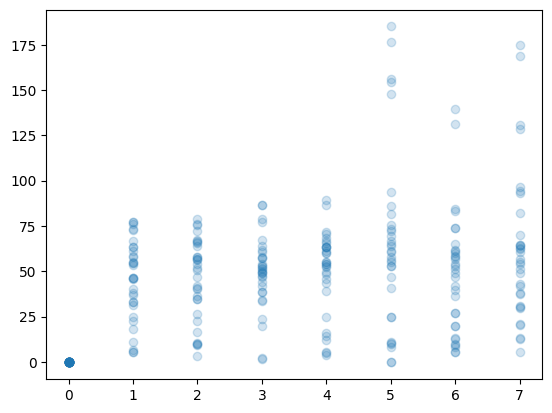

In [ ]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.2)